<img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Planet_Labs_logo.svg" alt="Drawing" style="width: 200px;"/>

# Your 101 Guide to Statistical API and starting to analyse your imagery quantitatively in Planet Insights Platform

One of the aims of the Planet Insights Platform is make it easy to access the data so you can then gain the maximum value from this data. The aim of this notebook is to show how you can take your first steps in quantitatively analysing satellite imagery and derived statistics from the platform. This is done through an examples based approach.

## Introduction to Statistical API

In the Process API examples, we have seen how to obtain satellite imagery. [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Python Library Imports

In [1]:
# Utilities
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
from typing import Any, Optional, Tuple
import numpy as np
from scipy.interpolate import interp1d
import getpass
import warnings
from pywaffle import Waffle
warnings.filterwarnings('ignore')

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    parse_time
)

### Helper Functions

In [2]:
# Helper Utility Functions

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

### Credentials

Credentials for Sentinel Hub services (client_id & client_secret) can be obtained in your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant documentation page.

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the the `config` class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook.

If you are a first time user of the Sentinel Hub Python package, you should create a profile so you don't need to create new credentials each time you open up Jupyter Lab. You can do this in the following cell:

In [3]:
# Only run this cell if you have not created a configuration.

#config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
#config.save("SH_creds")

In [4]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig("SH_creds")

### Creating an field of interest

Firstly, we will define some fields of interest in France for the first few examples. Our fields of interest and the time period we are using coincides with the temporal and spatial extent of the [Planetscope](https://collections.sentinel-hub.com/planetscope/sandbox-data.html) dataset within the Planet Sandbox Data Collection. We will use the [Sentinel-2 L2A](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) data collection in the first examples though.

In [5]:
fields="""{
"type": "FeatureCollection",
"name": "french_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018730388794967, 48.31900866284024 ], [ 3.02416040226223, 48.319921908340902 ], [ 3.024582971403651, 48.318306155176266 ], [ 3.019491013249525, 48.317392880750582 ], [ 3.018730388794967, 48.31900866284024 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.014150362764628, 48.311958271928731 ], [ 3.012550141917608, 48.312082666515273 ], [ 3.009640649468477, 48.312428205442302 ], [ 3.009328918134642, 48.314653420076148 ], [ 3.015334941833203, 48.314529031756756 ], [ 3.015272595566436, 48.314072938657887 ], [ 3.01566745525596, 48.313603020291822 ], [ 3.016311700012554, 48.313091633623024 ], [ 3.016914380591302, 48.312911956009131 ], [ 3.017142983569447, 48.312566420357946 ], [ 3.016789688057767, 48.312372919371228 ], [ 3.015064774677212, 48.312013558449088 ], [ 3.014150362764628, 48.311958271928731 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018867896950004, 48.310686665428022 ], [ 3.016685777613156, 48.30872390623729 ], [ 3.013339861296657, 48.311115145071334 ], [ 3.014025670231094, 48.311875342035918 ], [ 3.015542762722426, 48.311972093564449 ], [ 3.016290917923631, 48.311225719879126 ], [ 3.017371586547594, 48.311502155850299 ], [ 3.018285998460177, 48.310838707003604 ], [ 3.018867896950004, 48.310686665428022 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.991995616868946, 48.313513412817962 ], [ 2.996665005881652, 48.314890448089699 ], [ 2.997045318108931, 48.314595372231501 ], [ 2.997953841762987, 48.314258140589665 ], [ 2.998756723131687, 48.313710134417846 ], [ 2.993073168179571, 48.312094184517214 ], [ 2.991995616868946, 48.313513412817962 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.005412187109072, 48.316379852565653 ], [ 3.005496700937356, 48.313583670619266 ], [ 3.003341598316108, 48.314412705368852 ], [ 3.002242918548413, 48.314763987216573 ], [ 3.001313266437286, 48.314862345700547 ], [ 3.000785055010509, 48.315059062099621 ], [ 3.004165608141879, 48.315958327408346 ], [ 3.005412187109072, 48.316379852565653 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.994681699890837, 48.308712715603669 ], [ 2.994697906481011, 48.308691157048038 ], [ 2.994924798743444, 48.308259984022804 ], [ 2.994973418513966, 48.307559320087115 ], [ 2.991083836872255, 48.307483863397216 ], [ 2.990630052347389, 48.30864803990945 ], [ 2.994681699890837, 48.308712715603669 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.001245368911225, 48.311019428435152 ], [ 2.994519633989099, 48.308971417560947 ], [ 2.993352759496587, 48.310577496200999 ], [ 3.000175733959753, 48.312539214953759 ], [ 3.000775377796184, 48.31147213553583 ], [ 3.001002270058617, 48.311213446255813 ], [ 3.001245368911225, 48.311019428435152 ] ] ] ] } }
]
}
"""

In [120]:
fields_gdf = geopandas.read_file(fields)

fields_gdf["area"] = fields_gdf.area
fields_gdf.explore("area", cmap="tab10", legend=False)

## 1. How to create an NDVI time series for a field of interest

### The Evalscript

In this evalscript, we are calculating NDVI. Let's remind ourselves that evalscripts operate slightly differently with Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [7]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. he aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 

**NOTE:**
If a timeRange is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

In [8]:
fields_gdf = geopandas.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z'),
        aggregation_interval='P5D',
        size=[368.043, 834.345],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()
response1

[{'data': [{'interval': {'from': '2023-01-01T00:00:00Z',
     'to': '2023-01-06T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': -0.007692307699471712,
         'max': 0.05020453780889511,
         'mean': 0.024430520074909565,
         'stDev': 0.009480145820032558,
         'sampleCount': 306912,
         'noDataCount': 118325}}}}}},
   {'interval': {'from': '2023-01-06T00:00:00Z', 'to': '2023-01-11T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': -0.003138373838737607,
         'max': 0.06564551591873169,
         'mean': 0.027734270067214874,
         'stDev': 0.010870819468202996,
         'sampleCount': 306912,
         'noDataCount': 118325}}}}}},
   {'interval': {'from': '2023-01-11T00:00:00Z', 'to': '2023-01-16T00:00:00Z'},
    'outputs': {'ndvi': {'bands': {'B0': {'stats': {'min': 0.14532871544361115,
         'max': 0.6436322331428528,
         'mean': 0.26647175774146503,
         'stDev': 0.05245365684282068,
         'sampleCo

### Manipulation and Visualisation of our Output

However, as it is clear to see, our response is not that useful in `json` format. It's difficult to read from a human perspective. So, let's transform it into a `pandas` dataframe. To help us achieve this, let's define some helper functions. 

In [9]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

date  ndvi_min  ndvi_max  ndvi_mean  ndvi_stDev
0   2023-01-01 -0.007692  0.050205   0.024431    0.009480
0   2023-01-06 -0.003138  0.065646   0.027734    0.010871
0   2023-01-11  0.145329  0.643632   0.266472    0.052454
0   2023-01-16  0.002421  0.188039   0.079165    0.024330
0   2023-01-21 -0.009227  0.025436   0.005616    0.005308
..         ...       ...       ...        ...         ...
0   2023-12-02  0.043349  0.439589   0.177111    0.100790
0   2023-12-07  0.142470  0.212240   0.184907    0.009652
0   2023-12-12  0.049980  0.186453   0.090181    0.024196
0   2023-12-17  0.011880  0.047857   0.030997    0.005790
0   2023-12-22  0.010209  0.176540   0.084169    0.025579

[72 rows x 5 columns]

We can take this another step further, and display the data in a time series using the Matplotlib python library:

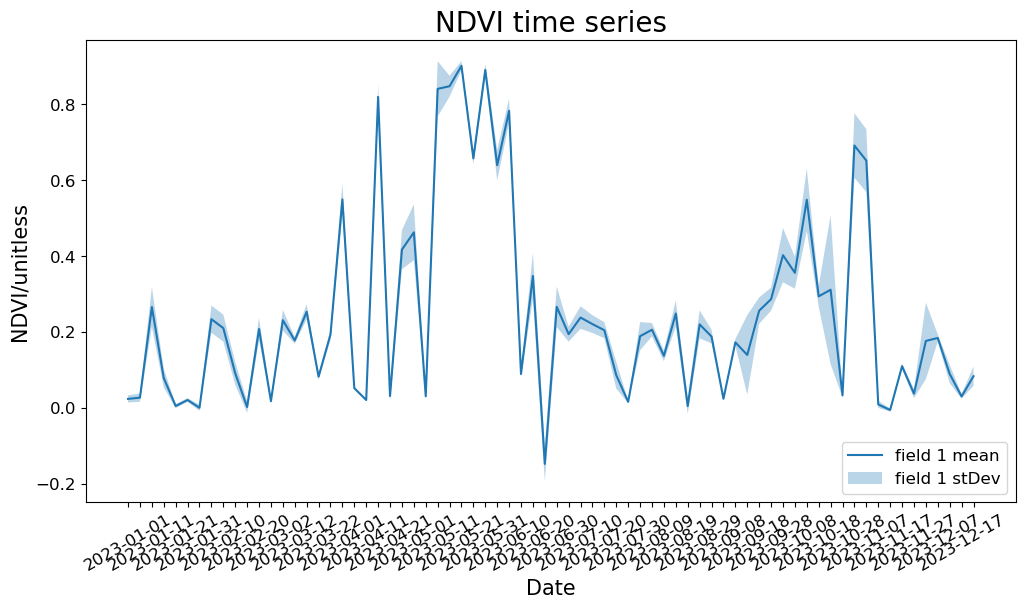

In [10]:
fig_stat, ax_stat =  plt.subplots(1, 1, figsize=(12,6))
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['ndvi_mean']
ndvi_std_field1 = result_df1['ndvi_stDev']
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)
ax_stat.set_xlabel('Date', size=15)
ax_stat.set_ylabel('NDVI/unitless', size=15)
ax_stat.legend(loc='lower right', prop={'size': 12})
ax_stat.set_title('NDVI time series', fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

## 2. Removing cloudy acquisitions from your NDVI time series

However, not filtering out the cloudy acquisitions means we have a very noisy time series which is not reflective of the NDVI values on the land surface. In the second example, we will filter out the cloudiest acquisitions.

### The Evalscript

This stays the same as the previous example, so we do not need to redefine it here.

### The Request Body

The request is only slightly adjusted from previously. We have added an additional argument: 

```
other_args={"dataFilter": {"maxCloudCoverage": 10}},
```
This will filter our data and means we will only use Sentinel-2 data where the cloud cover percentage of the scene was below 10%            

In [11]:
fields_gdf = geopandas.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z'),
        aggregation_interval='P5D',
        size=[368.043, 834.345],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,
            other_args={"dataFilter": {"maxCloudCoverage": 10}},            
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [12]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

date  ndvi_min  ndvi_max  ndvi_mean  ndvi_stDev
0  2023-01-11  0.145329  0.643632   0.266472    0.052454
0  2023-02-10  0.172257  0.529973   0.210947    0.035685
0  2023-04-01  0.408534  0.762193   0.547456    0.042747
0  2023-05-21  0.754660  0.919490   0.901890    0.012367
0  2023-05-31  0.712882  0.912911   0.890964    0.015692
0  2023-06-10  0.624567  0.858387   0.783308    0.031736
0  2023-06-20  0.184602  0.685888   0.348287    0.060611
0  2023-08-29  0.182271  0.564184   0.218427    0.036790
0  2023-09-03  0.161612  0.367647   0.188733    0.018061
0  2023-10-03  0.192443  0.639291   0.403055    0.071359
0  2023-12-12  0.049980  0.186453   0.090181    0.024196

We can take this another step further, and display the data in a time series using the Matplotlib python library:

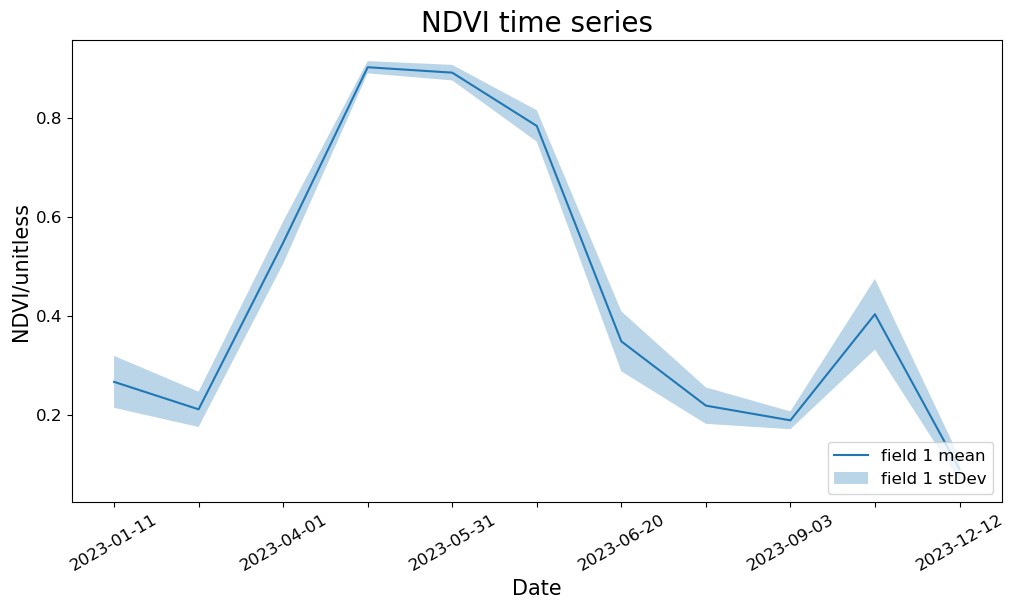

In [13]:
fig_stat, ax_stat =  plt.subplots(1, 1, figsize=(12,6))
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['ndvi_mean']
ndvi_std_field1 = result_df1['ndvi_stDev']
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)
ax_stat.set_xlabel('Date', size=15)
ax_stat.set_ylabel('NDVI/unitless', size=15)
ax_stat.legend(loc='lower right', prop={'size': 12})
ax_stat.set_title('NDVI time series', fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

We now have a much smoother NDVI time series. We have less data points now though. In your own time, try experimenting with the cloud coverage filter and see if you can find the sweet point between the number of data points and smoothness of the time series plot.

## 3. Creating custom datamasks to remove cloudy pixels

However, many data collections available in Planet Insights Platform will not have cloud cover metadata associated with each scene, for example, Planetscope. In these instances, you can create a custom datamask using the data quality bands present in the Planetscope data collection. You can read more about generating custom data masks [here](https://docs.sentinel-hub.com/api/latest/user-guides/datamask/).

### The Evalscript

In this evalscript, we calculate NDVI using Planetscope. We also have an additional function where we generate a `dataMask` using the `clear` band. You can see how this affects the resulting time series by switching the dataMask return from `samples.dataMask` to `clear`.

In [14]:
evalscript = """
//VERSION=3
//NDVI

function setup() {
  return {
    input: [{
      bands: [
        "Red",
        "NIR",
        "dataMask",
        "clear"
      ]
    }],
    output: [
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(samples) {
  let ndvi = (samples.NIR - samples.Red) / (samples.NIR + samples.Red);
  const indexVal = samples.dataMask === 1 ? ndvi : NaN;
  const clear = samples.dataMask * samples.clear;
  

  return {
    index: [indexVal],
    dataMask: [samples.dataMask], // change 'samples.dataMask' to 'clear' to mask out cloudy pixels using the 'clear' band
  };
}
"""

### The Request Body

Planetscope is located in a BYOC collection. For this you need the collection ID, which can be found on the Public Collections page for the corresponding dataset.

In [15]:
fields_gdf = geopandas.read_file(fields)

field1 = fields_gdf.geometry.values[4]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-05-01T00:00:00Z', '2023-04-29T23:59:59Z'),
        aggregation_interval='P5D',
        size=[1500,1050],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            data_collection=DataCollection.define_byoc('ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a'),
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [16]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

date  index_min  index_max  index_mean  index_stDev
0   2022-05-01   0.227614   0.723481    0.308343     0.057653
0   2022-05-06   0.233693   0.675031    0.322806     0.050467
0   2022-05-11   0.318288   0.602267    0.433791     0.038291
0   2022-05-16   0.161354   0.275168    0.223954     0.010673
0   2022-05-21   0.134141   0.233815    0.181955     0.012504
..         ...        ...        ...         ...          ...
0   2023-04-01   0.625856   0.913602    0.857957     0.025754
0   2023-04-06   0.623402   0.911932    0.862717     0.024616
0   2023-04-11   0.067353   0.346229    0.145999     0.045886
0   2023-04-16   0.642114   0.918633    0.864824     0.025669
0   2023-04-21   0.011817   0.053904    0.035682     0.005809

[71 rows x 5 columns]

We can take this another step further, and display the data in a time series using the Matplotlib python library:

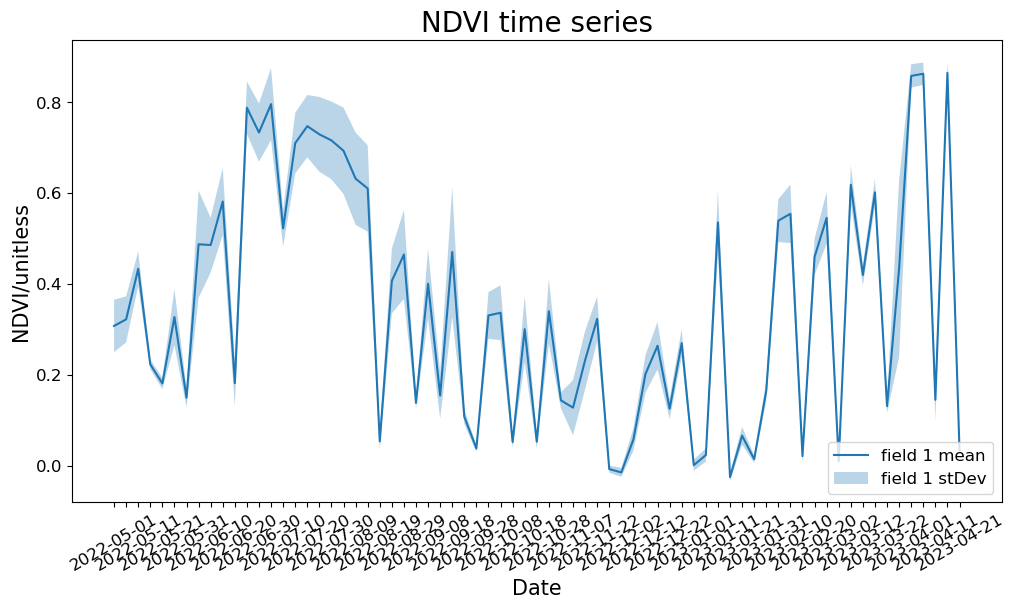

In [17]:
fig_stat, ax_stat =  plt.subplots(1, 1, figsize=(12,6))
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['index_mean']
ndvi_std_field1 = result_df1['index_stDev']
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)
ax_stat.set_xlabel('Date', size=15)
ax_stat.set_ylabel('NDVI/unitless', size=15)
ax_stat.legend(loc='lower right', prop={'size': 12})
ax_stat.set_title('NDVI time series', fontsize=20)
for label in ax_stat.get_xticklabels()[1::2]:
    label.set_visible(False)

## 4. Outputting multiple outputs from a single statistical API request

It is also possible to define multiple outputs from your evalscript. In this example, we generate NDVI and NDWI time series in the same request and then plot them on the same plot.

### The Evalscript

In [123]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "Green",
          "Red",
          "NIR",
          "dataMask",
          "clear"
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "ndwi",
        bands: 1
      },  
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function evaluatePixel(samples) {

    const clear = samples.dataMask * samples.clear;

    return {
      ndvi: [index(samples.NIR, samples.Red)],
      ndwi: [index(samples.NIR, samples.Green)],
      dataMask: [clear]
    };
    }
"""

### The Request Body

In [130]:
fields_gdf = geopandas.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-05-01T00:00:00Z', '2023-04-30T23:59:59Z'),
        aggregation_interval='P5D',
        size=[368.043, 834.345],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            data_collection=DataCollection.define_byoc('ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a'),
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [131]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

date  ndvi_min  ndvi_max  ndvi_mean  ndvi_stDev  ndwi_min  ndwi_max  \
0  2022-05-01  0.676696  0.889956   0.851188    0.021937  0.647923  0.810247   
0  2022-05-06  0.578130  0.877574   0.832766    0.025277  0.615952  0.834304   
0  2022-05-26  0.622755  0.871334   0.820498    0.038146  0.584947  0.816188   
0  2022-06-05  0.583969  0.813457   0.770311    0.037264  0.556978  0.743518   
0  2022-06-10  0.562682  0.726062   0.673739    0.028529  0.536030  0.666667   
0  2022-06-15  0.399956  0.659800   0.577956    0.060179  0.484802  0.634376   
0  2022-06-25  0.256047  0.527698   0.382017    0.037429  0.396815  0.584043   
0  2022-06-30  0.240836  0.462052   0.296287    0.024805  0.348864  0.517034   
0  2022-07-05  0.225070  0.498524   0.300983    0.024236  0.370948  0.556865   
0  2022-07-10  0.213779  0.377060   0.260848    0.016534  0.302146  0.429905   
0  2022-07-15  0.212169  0.419490   0.271444    0.020654  0.373782  0.510043   
0  2022-07-20  0.232570  0.557629   0.301798    0.031522  0.378219  0.562411   
0  2022-07-25  0.242378  0.639898   0.318466    0.045578  0.395931  0.627119   
0  2022-07-30  0.265802  0.592304   0.322790    0.038290  0.393388  0.607566   
0  2022-08-04  0.212447  0.699641   0.278651    0.054563  0.356214  0.667587   
0  2022-08-09  0.225689  0.605381   0.299806    0.039905  0.359391  0.620191   
0  2022-08-14  0.320802  0.701614   0.402297    0.043609  0.424679  0.665337   
0  2022-08-29  0.473403  0.757045   0.653705    0.029947  0.526554  0.709947   
0  2022-09-08  0.496708  0.844516   0.811059    0.031954  0.537757  0.746456   
0  2022-09-18  0.284160  0.893274   0.713948    0.120983  0.426737  0.715302   
0  2022-10-03  0.456334  0.824675   0.762975    0.050781  0.487789  0.716605   
0  2022-10-08  0.404916  0.835824   0.784719    0.045482  0.498344  0.729444   
0  2022-10-18  0.336108  0.839577   0.789480    0.051913  0.422452  0.736334   
0  2022-10-28  0.387768  0.841310   0.780252    0.060238  0.439503  0.747037   
0  2022-11-22  0.342907  0.779523   0.683054    0.051615  0.367529  0.672816   
0  2022-12-12 -0.016774  0.283255   0.187119    0.033332 -0.014120  0.257224   
0  2022-12-17 -0.182837  0.407753   0.200937    0.042538 -0.206943  0.381184   
0  2022-12-27  0.229868  0.283718   0.264458    0.012943  0.280586  0.344956   
0  2023-01-06 -0.031934  0.504997   0.218588    0.120230 -0.023678  0.516383   
0  2023-01-11  0.090485  0.489120   0.276578    0.040820  0.195588  0.550107   
0  2023-01-16 -0.019404  0.002655  -0.007518    0.004868 -0.005781  0.014337   
0  2023-02-05  0.187333  0.509385   0.282165    0.030051  0.296687  0.526261   
0  2023-02-10  0.180837  0.519208   0.256088    0.034628  0.313496  0.562385   
0  2023-02-25  0.191600  0.500242   0.254402    0.029118  0.307947  0.529499   
0  2023-03-07  0.284107  0.642157   0.369944    0.039522  0.430392  0.684658   
0  2023-03-17  0.260086  0.531282   0.317248    0.025748  0.278707  0.489012   
0  2023-04-01  0.476386  0.766901   0.584079    0.035348  0.519433  0.702545   
0  2023-04-06  0.509665  0.794861   0.659525    0.036883  0.551039  0.736543   
0  2023-04-16  0.678713  0.870000   0.827337    0.022284  0.642164  0.774792   

   ndwi_mean  ndwi_stDev  
0   0.781065    0.016065  
0   0.787754    0.020345  
0   0.760109    0.037426  
0   0.691613    0.045833  
0   0.618062    0.023768  
0   0.580515    0.031629  
0   0.486634    0.023467  
0   0.395880    0.018347  
0   0.434132    0.018176  
0   0.350783    0.013321  
0   0.429193    0.016102  
0   0.430086    0.020477  
0   0.448626    0.027839  
0   0.447601    0.023301  
0   0.409859    0.036722  
0   0.421143    0.026846  
0   0.482890    0.026567  
0   0.627820    0.017836  
0   0.687511    0.016705  
0   0.601324    0.064854  
0   0.663179    0.030603  
0   0.690701    0.024089  
0   0.691151    0.031594  
0   0.697583    0.037475  
0   0.595886    0.036711  
0   0.166752    0.031276  
0   0.178162    0.042052  
0   0.317653    0.020625  
0   0.272370    0.139528 

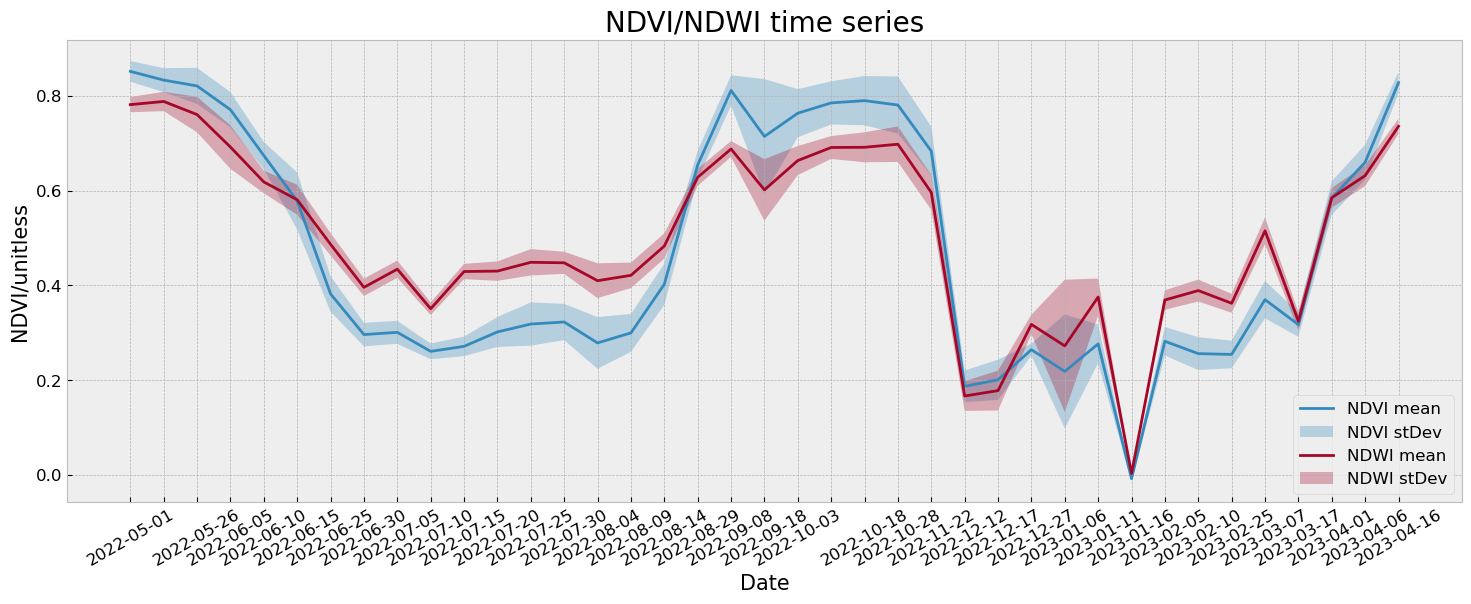

In [132]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))
t1 = result_df1["date"]
t2 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)
ax_stat.plot(t2, ndwi_mean_field1, label="NDWI mean")
ax_stat.fill_between(
    t2,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="NDWI stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI/NDWI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

## Side Quest! Fine tuning the Color Palettes in Matplotlib and even the theme!

As we start to make more complex plots we may want to make them more colourful or if it is for an academic publication less colourful. With Matplotlib, there is the flexibility to either change the colours of different time series or even use a completely different theme. So let's get to it! We'll use the previous example as our test dummy:

### Changing colours:

This one is easy, we have two functions for each of our dataseries called `ax_stat.plot()` and `ax_stat.fill_between()`. We can add an extra input to the function called `color` and after the `=` sign you can then type in your colour as a string. You can find these colours by visiting this [page](https://matplotlib.org/stable/gallery/color/named_colors.html). In the example below we have changed the NDVI data series to be green and the NDWI data series to be blue. This makes more sense than in the previous visualisation. In addition, in the `ax_stat.fill_between()` function there is an `alpha` input; this defines how seethrough the standard deviation data series is.

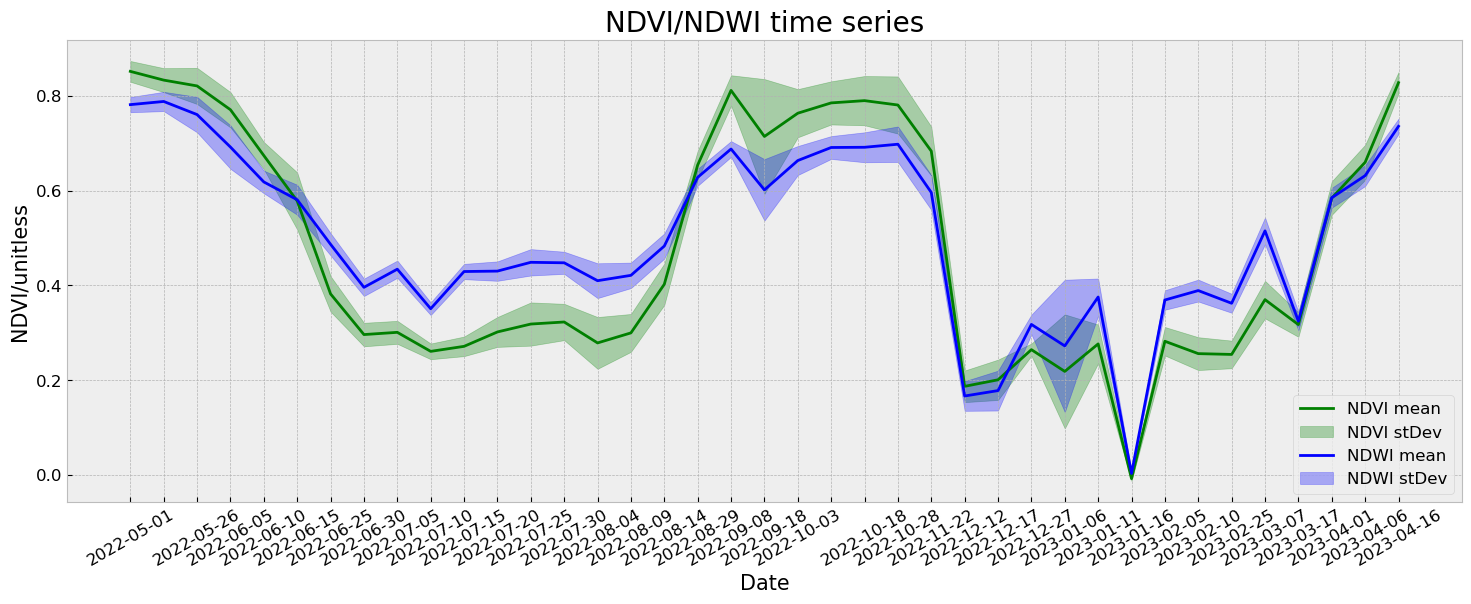

In [133]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))
t1 = result_df1["date"]
t2 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="NDVI mean", color="green")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    color="green",
    alpha=0.3,
    label="NDVI stDev",
)
ax_stat.plot(t2, ndwi_mean_field1, label="NDWI mean", color="blue")
ax_stat.fill_between(
    t2,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    color="blue",
    alpha=0.3,
    label="NDWI stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI/NDWI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

### Changing the style of your plots

You can also change the theme of your plots too using some predefined styles found as part of the python library. You can use the following function to return back all the different styles available to you. You can preview those styles on this [reference page](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).

In [23]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

Once you have decided on the style you want you can the below function to implement it. Let's use the `bmh` theme for the rest of the notebook.

In [24]:
plt.style.use('bmh')

We can plot the time series again with the new style:

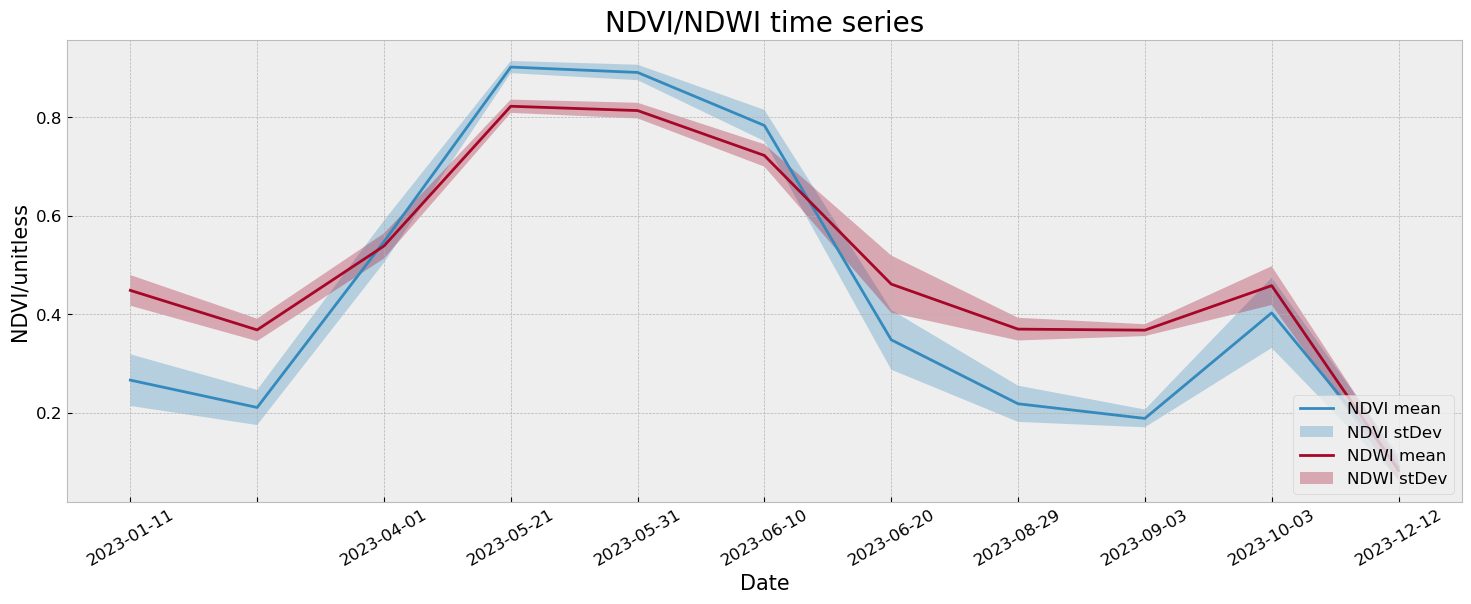

In [25]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))
t1 = result_df1["date"]
t2 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]
ax_stat.plot(t1, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)
ax_stat.plot(t2, ndwi_mean_field1, label="NDWI mean")
ax_stat.fill_between(
    t2,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="NDWI stDev",
)
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Date", size=15)
ax_stat.set_ylabel("NDVI/unitless", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12})
ax_stat.set_title("NDVI/NDWI time series", fontsize=20)
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

## 5. Making Multiple Requests to compare several fields of interest

Now that we have learnt how to plot the data for the first field, let's take this another step forward and compare the NDVI time series of the first field with the second field. We will now run the same request for our second field and then transform the response into a second Pandas dataframe. In addition, to making multiple requests, we will also use the Planet Fusion dataset to generate our NDVI time series statistics. 

### The Evalscript

In [26]:
evalscript = """
//VERSION=3
//NDVI

function setup() {
  return {
    input: [{
      bands: [
        "Red",
        "NIR",
        "dataMask",
        "clear"
      ]
    }],
    output: [
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(samples) {
  let ndvi = (samples.NIR - samples.Red) / (samples.NIR + samples.Red);
  const indexVal = samples.dataMask === 1 ? ndvi : NaN;
  const clear = samples.dataMask * samples.clear;
  

  return {
    index: [indexVal],
    dataMask: [clear], // change 'samples.dataMask' to 'clear' to mask out cloudy pixels using the 'clear' band
  };
}
"""

### The Request Body

In [27]:
aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-05-01T00:00:00Z', '2023-04-29T23:59:59Z'),
        aggregation_interval='P5D',
        size=[2500,1751],        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc('ccb1f8f0-e5bf-4c31-afe5-d8803bcbde2a'))

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [28]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 417 ms, sys: 16.7 ms, total: 433 ms
Wall time: 2min 37s


7

### Manipulation and Visualisation of our Output

In [29]:
ndvi_dfs = [stats_to_df(polygon_stats) for polygon_stats in ndvi_stats]

for df, id in zip(ndvi_dfs, fields_gdf["id"].values):
    df["id"] = id

ndvi_df = pd.concat(ndvi_dfs)

ndvi_df

interval_from interval_to  index_B0_min  index_B0_max  index_B0_mean  \
0     2022-05-01  2022-05-06      0.664657      0.889956       0.851485   
1     2022-05-06  2022-05-11      0.578130      0.877574       0.833025   
2     2022-05-26  2022-05-31      0.622727      0.871334       0.820786   
3     2022-06-05  2022-06-10      0.583969      0.813457       0.770494   
4     2022-06-10  2022-06-15      0.562682      0.726062       0.673914   
..           ...         ...           ...           ...            ...   
41    2023-03-27  2023-04-01      0.437070      0.850929       0.782940   
42    2023-04-01  2023-04-06      0.586240      0.918395       0.875277   
43    2023-04-06  2023-04-11      0.575894      0.926606       0.881742   
44    2023-04-16  2023-04-21      0.581786      0.920775       0.881674   
45    2023-04-21  2023-04-26      0.012810      0.059937       0.036347   

    index_B0_stDev  index_B0_sampleCount  index_B0_noDataCount  id  
0         0.021317               4377500               1699832   1  
1         0.024489               4377500               1699832   1  
2         0.037768               4377500               1699832   1  
3         0.037073               4377500               1699832   1  
4         0.028420               4377500               1699832   1  
..             ...                   ...                   ...  ..  
41        0.046809               4377500               2597208   7  
42        0.024487               4377500               2398538   7  
43        0.029247               4377500               2398538   7  
44        0.031873               4377500               2398538   7  
45        0.005050               4377500               4035992   7  

[295 rows x 9 columns]

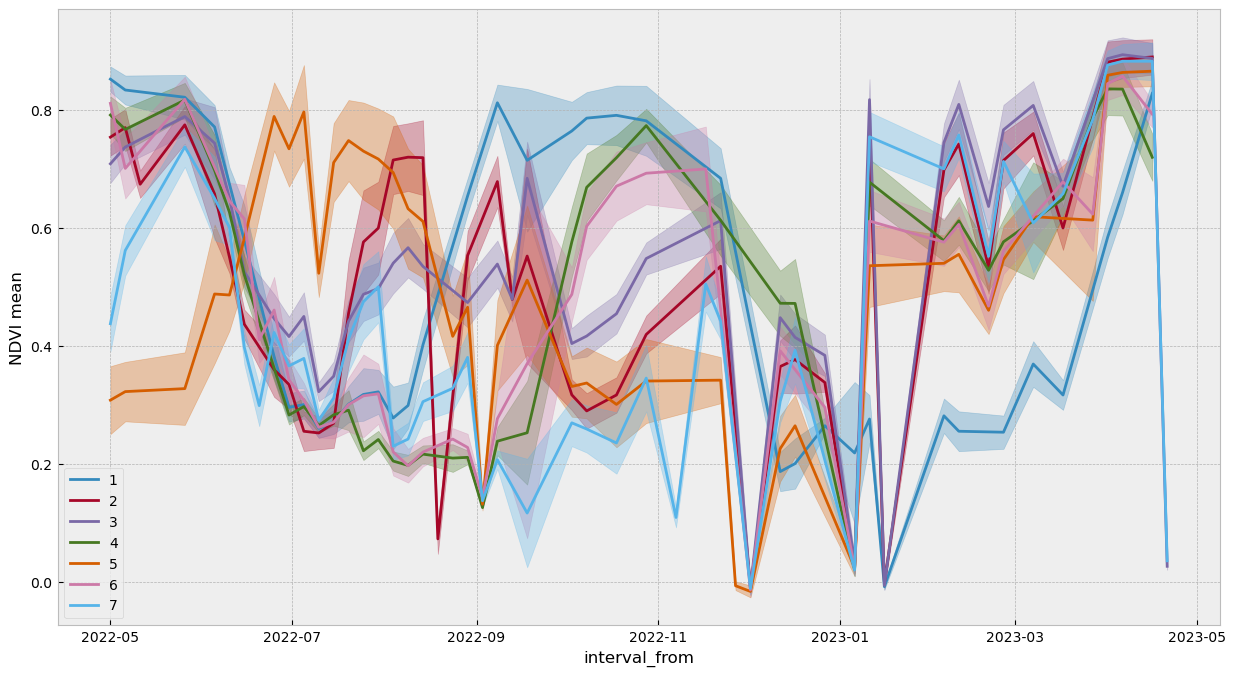

In [30]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_ylabel("NDVI mean")

for idx, id in enumerate(fields_gdf["id"].values):
    series = ndvi_df[ndvi_df["id"] == id]

    series.plot(ax=ax, x="interval_from", y="index_B0_mean", color=f"C{idx}", label=id)

    ax.fill_between(
        series.interval_from.values,
        series["index_B0_mean"] - series["index_B0_stDev"],
        series["index_B0_mean"] + series["index_B0_stDev"],
        color=f"C{idx}",
        alpha=0.3,
    );

## 6. How to plot a spectral signature plot for a field of interest

As well as creating time series with Statistical API, we can also derive more simple analyses like a spectral signature plot using the API output. This can be useful if you want to compare the spectral response of different land cover types. For this example, let's compare the spectral signature of four polygons; one will be urban, the second forest, the third grassland, and fourth terrestrial water. Firstly, let's build the evalscript.

### Creating an field of interest

For this example we have created some fields of interests for the different land cover types in and around Zurich, Switzerland. We will use Sentinel-2 L2A to create the spectral signature plot.

In [31]:
land_cover_samples="""{
"type": "FeatureCollection",
"name": "zurich_landcover",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.539461050474173, 47.347751085073959 ], [ 8.545030558394702, 47.349820439748108 ], [ 8.557606866602345, 47.350307334939416 ], [ 8.567488251622636, 47.334115661516677 ], [ 8.548444127765348, 47.332532750321199 ], [ 8.539461050474173, 47.347751085073959 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.561020435972992, 47.399825441623598 ], [ 8.575752682730519, 47.395568955189852 ], [ 8.565511974618577, 47.384987056387466 ], [ 8.554013635685875, 47.390947237735197 ], [ 8.561020435972992, 47.399825441623598 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.525921486466855, 47.386606085799173 ], [ 8.534639710587191, 47.382048690811793 ], [ 8.528613879209898, 47.376926576724422 ], [ 8.521049537693726, 47.38035584375195 ], [ 8.525921486466855, 47.386606085799173 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.635924961396981, 47.406133316022533 ], [ 8.643361093734915, 47.4002325161401 ], [ 8.632335104406256, 47.402402004692235 ], [ 8.630924803445613, 47.403963981131589 ], [ 8.635924961396981, 47.406133316022533 ] ] ] ] } }
]
}
"""

In [134]:
lcs_gdf = geopandas.read_file(land_cover_samples)

#fields_gdf
lcs_gdf["area"] = lcs_gdf.area
lcs_gdf.explore("area", cmap="tab10", legend=False)

### The Evalscript

In this evalscript we will extract out statistics for every band from the Sentinel-2 L2A data collection. Each of these must be defined as a seperate output. This makes a long evalscript but actually there is just a lot of repetition here so nothing to worry about.

In [33]:
evalscript = """
//VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "dataMask"],
        },
      ],
      output: [
      {
        id: "B01",
        bands: 1
      },
      {
        id: "B02",
        bands: 1
      },
      {
        id: "B03",
        bands: 1
      },
      {
        id: "B04",
        bands: 1
      },
      {
        id: "B05",
        bands: 1
      },
      {
        id: "B06",
        bands: 1
      },
      {
        id: "B07",
        bands: 1
      },
      {
        id: "B08",
        bands: 1
      },
      {
        id: "B8A",
        bands: 1
      },
      {
        id: "B09",
        bands: 1
      },
      {
        id: "B11",
        bands: 1
      },
      {
        id: "B12",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}
  
function evaluatePixel(samples) {

    return {
      B01: [10 * samples.B01],
      B02: [10 * samples.B02],
      B03: [10 * samples.B03],
      B04: [10 * samples.B04],
      B05: [10 * samples.B05],
      B06: [10 * samples.B06],
      B07: [10 * samples.B07],
      B08: [10 * samples.B08],      
      B8A: [10 * samples.B8A],
      B09: [10 * samples.B09],
      B11: [10 * samples.B11],
      B12: [10 * samples.B12],      
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

In [34]:
lcs_gdf = geopandas.read_file(land_cover_samples)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2024-06-19T00:00:00Z', '2024-06-20T00:00:00Z'),
        aggregation_interval='P1D',
        size=[368.043, 834.345],        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.SENTINEL2_L2A)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [35]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

lcs_stats = client.download(download_requests)

len(lcs_stats)

CPU times: user 204 ms, sys: 5.84 ms, total: 210 ms
Wall time: 3.32 s


4

### Manipulation and Visualisation of our Output

We need to conduct some additional data handling before visualising the output. First, we concatenate the four requests into single pandas dataframe. We then set the index by the `id` column.

In [36]:
lcs_dfs = [stats_to_df(polygon_stats) for polygon_stats in lcs_stats]

for df, id in zip(lcs_dfs, lcs_gdf["id"].values):
    df["id"] = id

lcs_df = pd.concat(lcs_dfs)
lcs_df = lcs_df.set_index('id')

lcs_df

interval_from interval_to  B11_B0_min  B11_B0_max  B11_B0_mean  \
id                                                                  
1     2024-06-19  2024-06-20       0.101       0.295     0.120514   
2     2024-06-19  2024-06-20       0.938       2.612     1.880516   
3     2024-06-19  2024-06-20       1.048       3.060     1.889837   
4     2024-06-19  2024-06-20       1.992       3.335     2.409251   

    B11_B0_stDev  B11_B0_sampleCount  B11_B0_noDataCount  B01_B0_min  \
id                                                                     
1       0.007715              306912              106674       0.109   
2       0.214808              306912              142468       0.120   
3       0.289654              306912              147029       0.273   
4       0.334864              306912              180751       0.059   

    B01_B0_max  ...  B8A_B0_mean  B8A_B0_stDev  B8A_B0_sampleCount  \
id              ...                                                  
1        0.253  ...     0.132068      0.027116              306912   
2        0.249  ...     4.052434      0.559250              306912   
3        1.122  ...     1.776157      0.500932              306912   
4        0.776  ...     4.689731      0.755596              306912   

    B8A_B0_noDataCount  B09_B0_min  B09_B0_max  B09_B0_mean  B09_B0_stDev  \
id                                                                          
1               106674       0.058       0.166     0.113935      0.020703   
2               142468       2.845       5.333     4.032186      0.393938   
3               147029       1.110       3.098     1.764324      0.371665   
4               180751       2.617       5.853     4.641942      0.688304   

    B09_B0_sampleCount  B09_B0_noDataCount  
id                                          
1               306912              106674  
2               306912              142468  
3               306912              147029  
4               306912              180751  

[4 rows x 74 columns]

However, this dataframe needs cleaning up. Firstly, we define only the columns we need so only the mean of each band. We then transpose the dataframe, effectively flipping it. Now the `id` column is at the head of the table with the mean band values now rows, and the fields now columns.

In [37]:
lcs_df = lcs_df[["B01_B0_mean","B02_B0_mean","B03_B0_mean","B04_B0_mean","B05_B0_mean","B06_B0_mean","B07_B0_mean","B08_B0_mean","B8A_B0_mean","B09_B0_mean","B11_B0_mean","B12_B0_mean"]]
lcs_df = lcs_df.transpose()
lcs_df

id                  1         2         3         4
B01_B0_mean  0.183634  0.151388  0.623955  0.278710
B02_B0_mean  0.214120  0.180674  0.704832  0.334809
B03_B0_mean  0.281973  0.445938  0.898710  0.810878
B04_B0_mean  0.121946  0.231531  0.975119  0.566482
B05_B0_mean  0.121452  0.831108  1.208745  1.469843
B06_B0_mean  0.119926  3.039833  1.562751  3.625050
B07_B0_mean  0.129948  3.767564  1.675536  4.269117
B08_B0_mean  0.126112  3.844705  1.680290  4.390365
B8A_B0_mean  0.132068  4.052434  1.776157  4.689731
B09_B0_mean  0.113935  4.032186  1.764324  4.641942
B11_B0_mean  0.120514  1.880516  1.889837  2.409251
B12_B0_mean  0.100433  0.844474  1.650131  1.268895

Next, we can insert two additional columns, firstly the central wavelength of each band and the band name. We can then use these in the plot.

In [38]:
lcs_df.insert(4, "Band", ["Coastal", "Blue", "Green", "Red", "RedEdge1", "RedEdge2", "Rededge3", "NIR", "NarrowNIR", "WaterVapour", "SWIR1", "SWIR2"], True)
lcs_df.insert(4, "Wavelength", [442, 492, 559, 664, 704, 740, 782, 833, 864, 945, 1613, 2202], True)
lcs_df

id                  1         2         3         4  Wavelength         Band
B01_B0_mean  0.183634  0.151388  0.623955  0.278710         442      Coastal
B02_B0_mean  0.214120  0.180674  0.704832  0.334809         492         Blue
B03_B0_mean  0.281973  0.445938  0.898710  0.810878         559        Green
B04_B0_mean  0.121946  0.231531  0.975119  0.566482         664          Red
B05_B0_mean  0.121452  0.831108  1.208745  1.469843         704     RedEdge1
B06_B0_mean  0.119926  3.039833  1.562751  3.625050         740     RedEdge2
B07_B0_mean  0.129948  3.767564  1.675536  4.269117         782     Rededge3
B08_B0_mean  0.126112  3.844705  1.680290  4.390365         833          NIR
B8A_B0_mean  0.132068  4.052434  1.776157  4.689731         864    NarrowNIR
B09_B0_mean  0.113935  4.032186  1.764324  4.641942         945  WaterVapour
B11_B0_mean  0.120514  1.880516  1.889837  2.409251        1613        SWIR1
B12_B0_mean  0.100433  0.844474  1.650131  1.268895        2202        SWIR2

Finally, we can plot the spectral signature. In addition to connecting the points with a line, we're also using the `interp1D` function from scipy library to add the curves between the points.

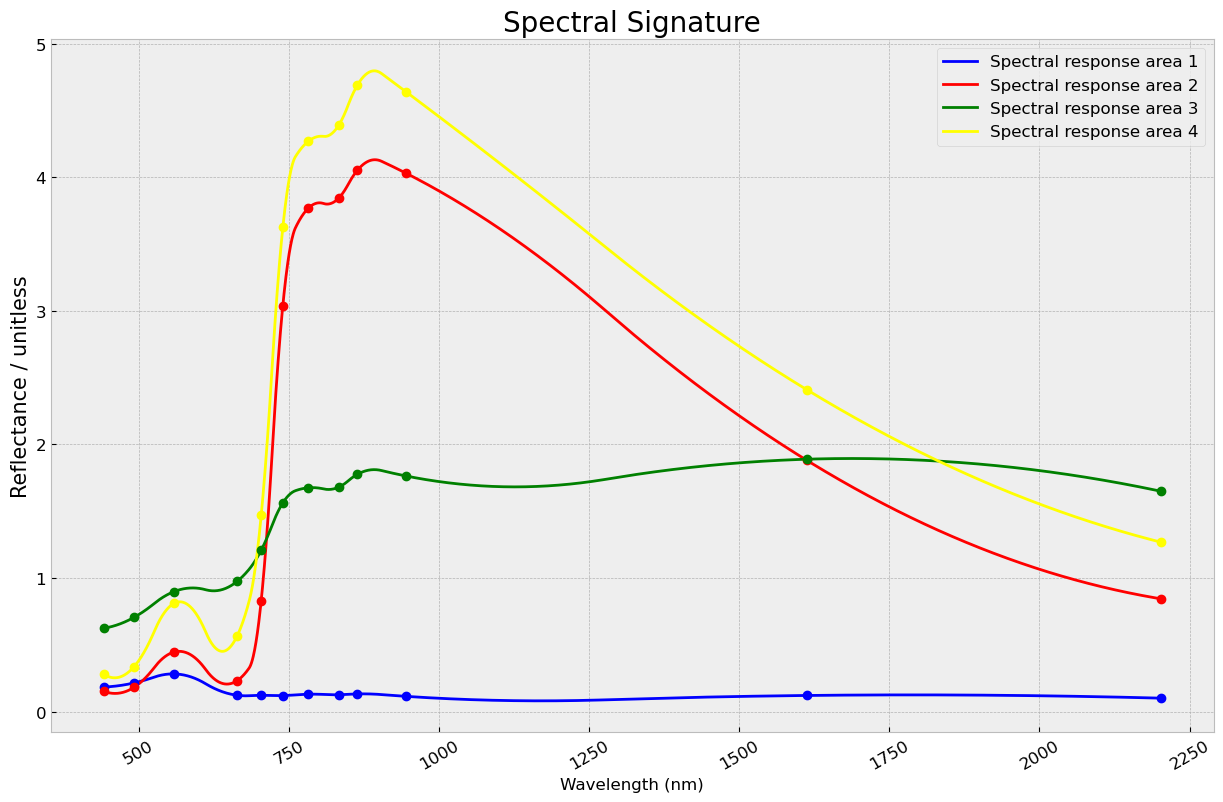

In [39]:
fig_stat, ax_stat =  plt.subplots(1, 1, figsize=(15,9))

a_spectralvalue = lcs_df[1]
b_spectralvalue = lcs_df[2]
c_spectralvalue = lcs_df[3]
d_spectralvalue = lcs_df[4]
wavelength = lcs_df["Wavelength"]

x = wavelength
a_y = a_spectralvalue
b_y = b_spectralvalue
c_y = c_spectralvalue
d_y = d_spectralvalue
fun = interp1d(x=x, y=a_y, kind=2)
a_x2 = np.linspace(start=442, stop=2202, num=2300)
a_y2 = fun(a_x2)
fun = interp1d(x=x, y=b_y, kind=2)
b_x2 = np.linspace(start=442, stop=2202, num=2300)
b_y2 = fun(b_x2)
fun = interp1d(x=x, y=c_y, kind=2)
c_x2 = np.linspace(start=442, stop=2202, num=2300)
c_y2 = fun(c_x2)
fun = interp1d(x=x, y=d_y, kind=2)
d_x2 = np.linspace(start=442, stop=2202, num=2300)
d_y2 = fun(d_x2)

ax_stat.plot(a_x2, a_y2, label='Spectral response area 1', color='blue')
ax_stat.plot(b_x2, b_y2, label='Spectral response area 2', color='red')
ax_stat.plot(c_x2, c_y2, label='Spectral response area 3', color='green')
ax_stat.plot(c_x2, d_y2, label='Spectral response area 4', color='yellow')
ax_stat.plot(x, a_y, ls='', marker='o', color='blue')
ax_stat.plot(x, b_y, ls='', marker='o', color='red')
ax_stat.plot(x, c_y, ls='', marker='o', color='green')
ax_stat.plot(x, d_y, ls='', marker='o', color='yellow')
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.legend(loc='upper right', prop={'size': 12})
ax_stat.set_title('Spectral Signature', fontsize=20)
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

Now we can compare the different spectral curves and we can see some distinct signatures for different land cover types, we could of course use spectral libraries to assist us like in the EO Browser application, but for this example we can use our remote sensing knowledge and expertise!
- Area 1 is clearly terrestrial water, with only a small peak in reflectance in the blue and green channels, but overall very little reflectance across the spectrum.
- Areas 2 and 4 are both vegetated land covers with peaks in the NIR and Red Edge parts of the spectrum. Checking the map from earlier, it seems likelier that area 2 is forest as it's curve is slightly lower than area 4. This means we can probably guess that area 2 is forest and area 4 is grassland.
- Lastly, area 3 is a sample of Zurich's inner city and the bright response accross the spectrum is a good indicator of built up areas.

Now we know the land cover types we can update the plot with appropiate labels and colour choices:

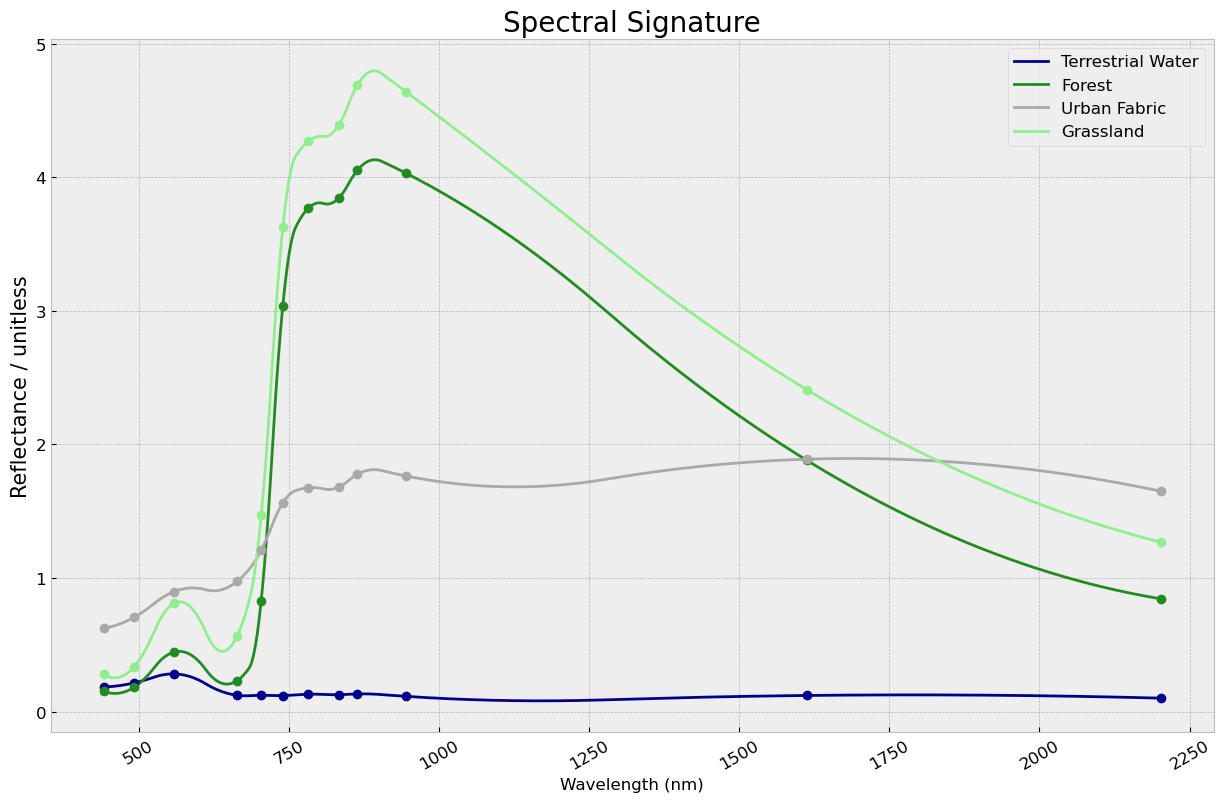

In [40]:
fig_stat, ax_stat =  plt.subplots(1, 1, figsize=(15,9))

ax_stat.plot(a_x2, a_y2, label='Terrestrial Water', color='darkblue')
ax_stat.plot(b_x2, b_y2, label='Forest', color='forestgreen')
ax_stat.plot(c_x2, c_y2, label='Urban Fabric', color='darkgrey')
ax_stat.plot(d_x2, d_y2, label='Grassland', color='lightgreen')
ax_stat.plot(x, a_y, ls='', marker='o', color='darkblue')
ax_stat.plot(x, b_y, ls='', marker='o', color='forestgreen')
ax_stat.plot(x, c_y, ls='', marker='o', color='darkgrey')
ax_stat.plot(x, d_y, ls='', marker='o', color='lightgreen')
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.legend(loc='upper right', prop={'size': 12})
ax_stat.set_title('Spectral Signature', fontsize=20)
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

## 7. How to create a Histogram & Box Plot of a certain band's values for a field of interest

### The Evalscript

In [41]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [42]:
geometry = Geometry(geometry={"type":"Polygon","coordinates":[[[-8.5309,39.322363],[-8.532446,39.32077],[-8.532532,39.318977],[-8.531501,39.317217],[-8.52944,39.316454],[-8.526864,39.31662],[-8.524846,39.318047],[-8.524245,39.320205],[-8.52519,39.321998],[-8.527852,39.322961],[-8.5309,39.322363]]]}, crs=CRS.WGS84)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    geometry=geometry,
    size=[512, 343.697],
    config=config
)

response = request.get_data()

### Manipulation and Visualisation of our Output

In [43]:
type(response)

list

In [44]:
# converting list to array
arr = np.array(response)

type(arr)

numpy.ndarray

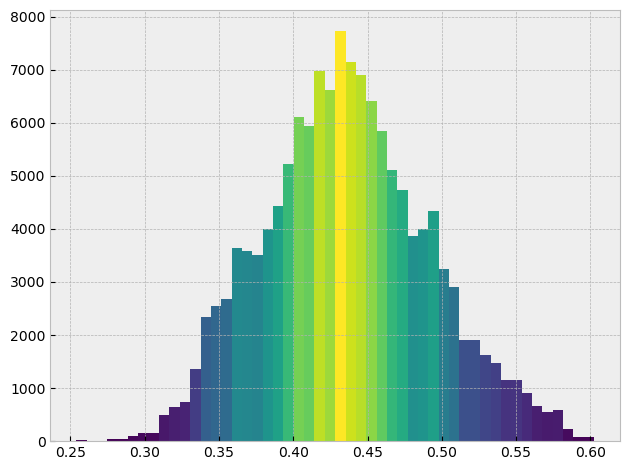

In [45]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

dist1 = arr.flatten()

fig, axs = plt.subplots(1, 1, tight_layout=True)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(dist1, bins=50)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)


With the same data, we can also very easily create a box plot with the following:

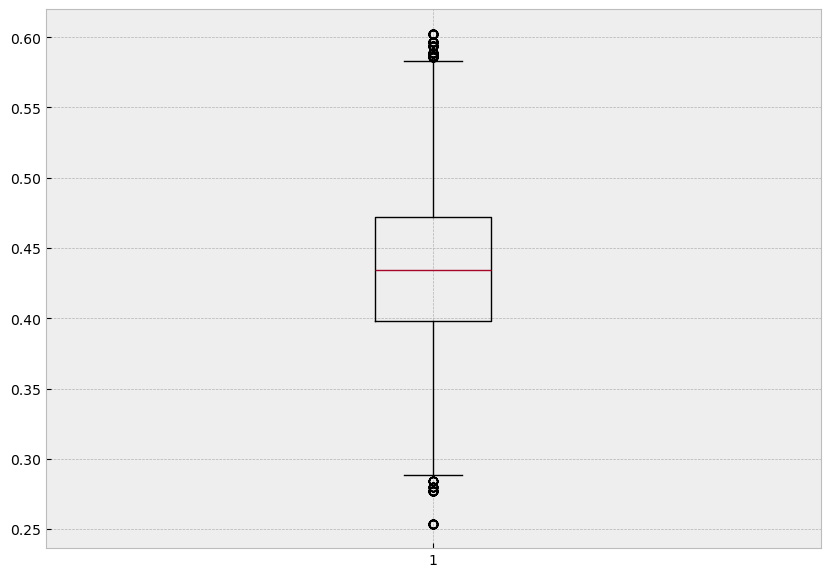

In [46]:
# filter out NaN values from the numpy array
filtered_data = dist1[~np.isnan(dist1)]

fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(filtered_data)

# show plot
plt.show()

## 8. Plotting and styling multiple box plots to compare different land cover types

### The Evalscript

In [47]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [48]:
lcs_gdf = geopandas.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [49]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config)

lcs_stats = client.download(download_requests)

len(lcs_stats)

CPU times: user 500 ms, sys: 16.1 ms, total: 516 ms
Wall time: 9.58 s


4

### Manipulation and Visualisation of our Output

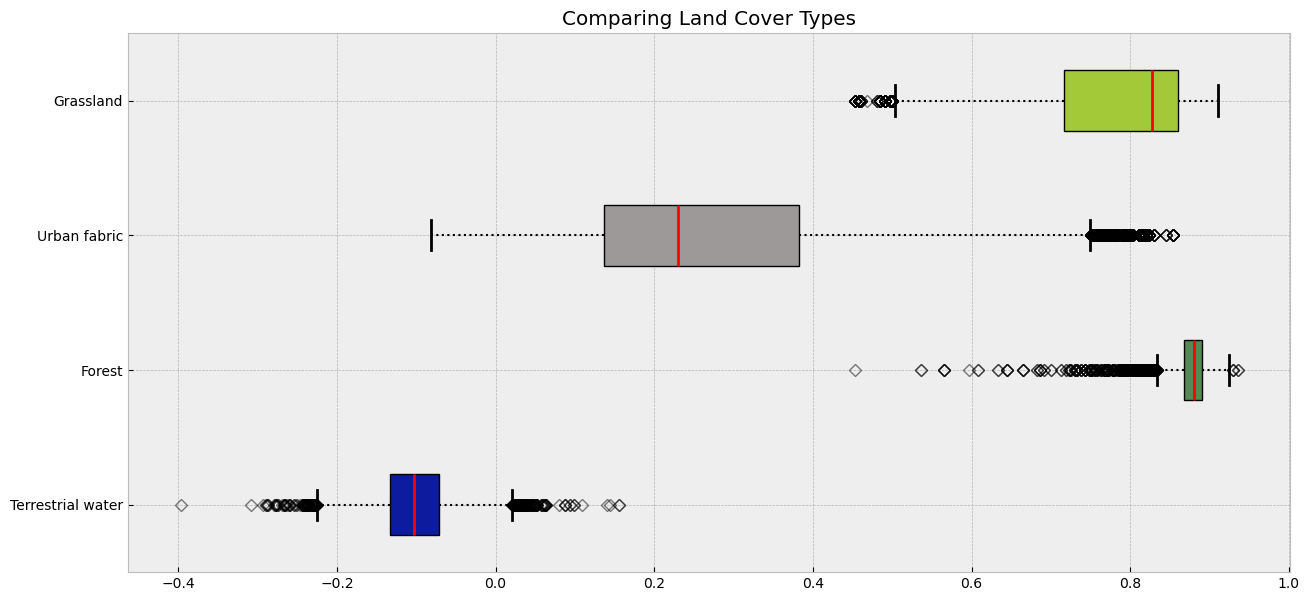

In [50]:
# converting list to array
arr1 = np.array(lcs_stats[0])
arr2 = np.array(lcs_stats[1])
arr3 = np.array(lcs_stats[2])
arr4 = np.array(lcs_stats[3])

type(arr)
dist1 = arr1.flatten()
dist2 = arr2.flatten()
dist3 = arr3.flatten()
dist4 = arr4.flatten()

filtered_data1 = dist1[~np.isnan(dist1)]
filtered_data2 = dist2[~np.isnan(dist2)]
filtered_data3 = dist3[~np.isnan(dist3)]
filtered_data4 = dist4[~np.isnan(dist4)]

# Creating dataset
data_1 = filtered_data1
data_2 = filtered_data2
data_3 = filtered_data3
data_4 = filtered_data4
data = [data_1, data_2, data_3, data_4]

fig = plt.figure(figsize =(15, 7))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                vert = 0)

colors = ['#0d1b9e', '#568a55', 
          '#9c9998', '#a3c938']

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#000000',
                linewidth = 1.5,
                linestyle =":")

# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#000000',
            linewidth = 2)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 2)

# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#000000',
              alpha = 0.5)
    
# x-axis labels
ax.set_yticklabels(['Terrestrial water', 'Forest', 
                    'Urban fabric', 'Grassland'])

# Adding title 
plt.title("Comparing Land Cover Types")

# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
    
# show plot
plt.show()

## 9. Creating a scatter plot comparing two spectral bands

### The Evalscript

In [51]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    return [samples.B04, samples.B08];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 2,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [52]:
lcs_gdf = geopandas.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    data_folder="test_dir",    
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        resolution=(0.00002, 0.00002),
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [53]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config).download(download_requests, max_threads=5)

lcs_stats = (download_requests)

len(lcs_stats)

CPU times: user 451 ms, sys: 30.6 ms, total: 482 ms
Wall time: 2.64 s


4

In [92]:
files = []

for folder, _, filenames in os.walk(download_requests[0].data_folder):
    for filename in filenames:
        if filename.endswith(".tiff"):
            files.append(os.path.join(folder, filename))

files

['test_dir/9d5417f62950fb0833bce43c77effdd6/response.tiff',
 'test_dir/63b38f8faa2fa8d833177c79c38f9029/response.tiff',
 'test_dir/bdc4852e8c252c7845a316e660c4a3dc/response.tiff',
 'test_dir/6c827344c292a7a935c4afcfb38d3403/response.tiff']

### Manipulation and Visualisation of our Output

In [93]:
import rasterio
src1 = rasterio.open(files[0])
src2 = rasterio.open(files[1])
src3 = rasterio.open(files[2])
src4 = rasterio.open(files[3])

In [94]:
combined_data = [src1, src2, src3, src4]
combined_data[1]

B4 = combined_data[1].read(1)
B8 = combined_data[1].read(2)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


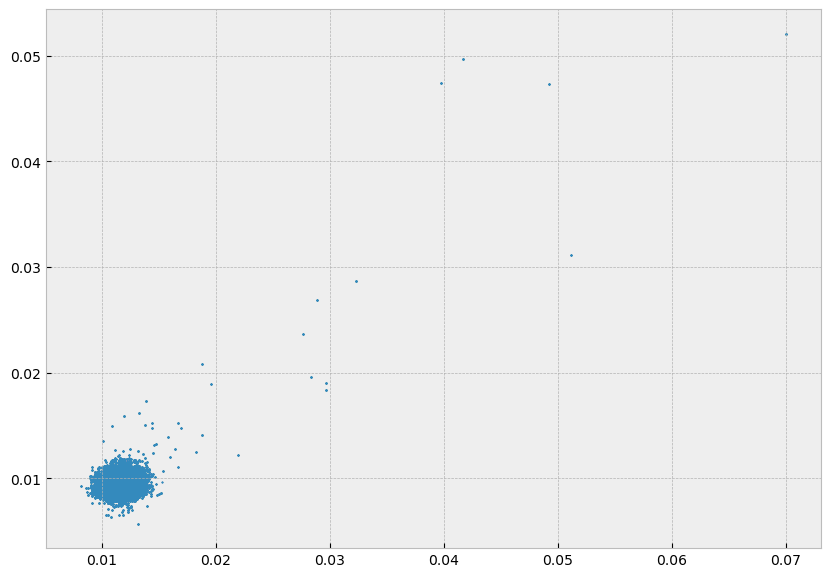

In [95]:
plt.figure(figsize=(10, 7))
plt.scatter(B4, B8, s=0.5, alpha=0.5)

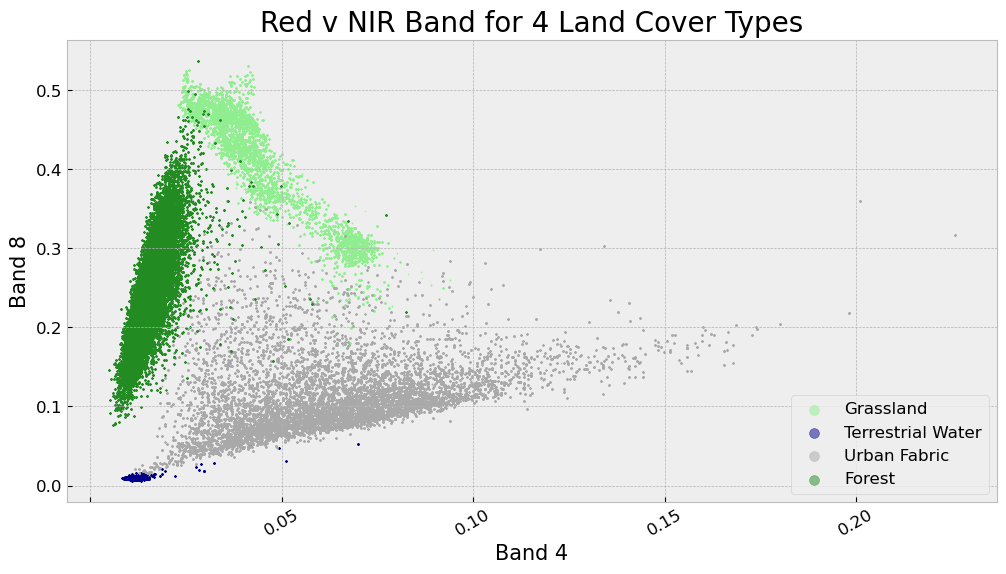

In [107]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))
arr1_B4 = combined_data[0].read(1)
arr1_B8 = combined_data[0].read(2)
arr2_B4 = combined_data[1].read(1)
arr2_B8 = combined_data[1].read(2)
arr3_B4 = combined_data[2].read(1)
arr3_B8 = combined_data[2].read(2)
arr4_B4 = combined_data[3].read(1)
arr4_B8 = combined_data[3].read(2)
ax_stat.scatter(arr1_B4, arr1_B8, s=0.5, alpha=0.5, label='Grassland', color='lightgreen')
ax_stat.scatter(arr2_B4, arr2_B8, s=0.5, alpha=0.5, label='Terrestrial Water', color='darkblue')
ax_stat.scatter(arr3_B4, arr3_B8, s=0.5, alpha=0.5, label='Urban Fabric', color='darkgrey')
ax_stat.scatter(arr4_B4, arr4_B8, s=0.5, alpha=0.5, label='Forest', color='forestgreen')
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)
ax_stat.set_xlabel("Band 4", size=15)
ax_stat.set_ylabel("Band 8", size=15)
ax_stat.legend(loc="lower right", prop={"size": 12}, markerscale=10.)
ax_stat.set_title("Red v NIR Band for 4 Land Cover Types", fontsize=20)
for label in ax_stat.get_xticklabels()[1::20]:
   label.set_visible(False)

## 10. Creating waffle charts of categorical raster datasets

### The Evalscript

In [97]:
CLC_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["CLC", "dataMask"],
    output: { 
      bands: 4, 
      sampleType: "AUTO"
    }
  }
}

const map = [
    [1, 0xe6004d],  //111 - Continuous urban fabric
    [2, 0xff0000],  //112 - Discontinuous urban fabric
    [3, 0xcc4df2],  //121 - Industrial or commercial units
    [4, 0xcc0000],  //122 - Road and rail networks and associated land
    [5, 0xe6cccc],  //123 - Port areas
    [6, 0xe6cce6],  //124 - Airports
    [7, 0xa600cc],  //131 - Mineral extraction sites
    [8, 0xa64d00],  //132 - Dump sites
    [9, 0xff4dff],  //133 - Construction sites
    [10, 0xffa6ff], //141 - Green urban areas
    [11, 0xffe6ff], //142 - Sport and leisure facilities
    [12, 0xffffa8], //211 - Non-irrigated arable land
    [13, 0xffff00], //212 - Permanently irrigated land
    [14, 0xe6e600], //213 - Rice fields
    [15, 0xe68000], //221 - Vineyards
    [16, 0xf2a64d], //222 - Fruit trees and berry plantations
    [17, 0xe6a600], //223 - Olive groves
    [18, 0xe6e64d], //231 - Pastures
    [19, 0xffe6a6], //241 - Annual crops associated with permanent crops
    [20, 0xffe64d], //242 - Complex cultivation patterns
    [21, 0xe6cc4d], //243 - Land principally occupied by agriculture with significant areas of natural vegetation
    [22, 0xf2cca6], //244 - Agro-forestry areas
    [23, 0x80ff00], //311 - Broad-leaved forest
    [24, 0x00a600], //312 - Coniferous forest
    [25, 0x4dff00], //313 - Mixed forest
    [26, 0xccf24d], //321 - Natural grasslands
    [27, 0xa6ff80], //322 - Moors and heathland
    [28, 0xa6e64d], //323 - Sclerophyllous vegetation
    [29, 0xa6f200], //324 - Transitional woodland-shrub
    [30, 0xe6e6e6], //331 - Beaches - dunes - sands
    [31, 0xcccccc], //332 - Bare rocks
    [32, 0xccffcc], //333 - Sparsely vegetated areas
    [33, 0x000000], //334 - Burnt areas
    [34, 0xa6e6cc], //335 - Glaciers and perpetual snow
    [35, 0xa6a6ff], //411 - Inland marshes
    [36, 0x4d4dff], //412 - Peat bogs
    [37, 0xccccff], //421 - Salt marshes
    [38, 0xe6e6ff], //422 - Salines
    [39, 0xa6a6e6], //423 - Intertidal flats
    [40, 0x00ccf2], //511 - Water courses
    [41, 0x80f2e6], //512 - Water bodies
    [42, 0x00ffa6], //521 - Coastal lagoons
    [43, 0xa6ffe6], //522 - Estuaries
    [44, 0xe6f2ff], //523 - Sea and ocean
    [48, 0xffffff]  //999 - NODATA
  ];

const visualizer = new ColorMapVisualizer(map);

function evaluatePixel(sample) {
  return [visualizer.process(sample.CLC)[0], visualizer.process(sample.CLC)[1], visualizer.process(sample.CLC)[2], sample.dataMask];
}
"""

In [98]:
bbox = BBox(bbox=[8.379459, 47.298325, 8.715975, 47.480553], crs=CRS.WGS84)

config.instance_id = "creodias.sentinel-hub.com/api/"
config.sh_base_url = "https://creodias.sentinel-hub.com/"

request = SentinelHubRequest(
    evalscript=CLC_evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.define_byoc('cbdba844-f86d-41dc-95ad-b3f7f12535e9'),          
            time_interval=('2018-01-01', '2018-01-01'),          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG),
    ],
    bbox=bbox,
    size=[1000, 800],
    config=config
)

response = request.get_data()

Image type: uint8


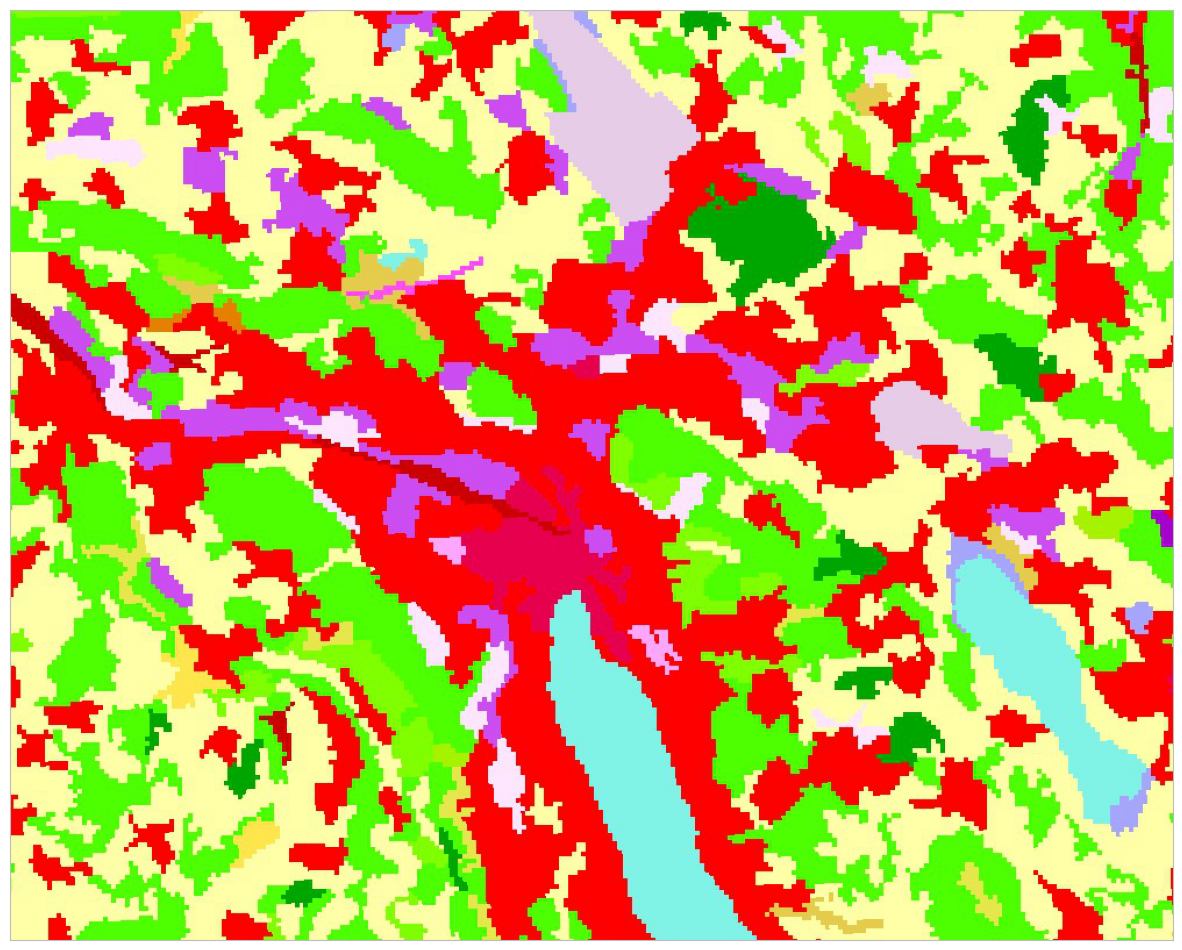

In [99]:
image = response[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1 / 255,clip_range=(0, 1))

In [100]:
stat_evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "CLC",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "data",
        bands: 1,
        sampleType: "UINT8"
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    return {
        data: [samples.CLC],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

In [101]:
bbox = BBox(bbox=[8.379459, 47.298325, 8.715975, 47.480553], crs=CRS.WGS84)

calculations = {
    "default": {
        "histograms": {
            "default": {
                "bins": [
                    0,
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
                    8,
                    9,
                    10,
                    11,
                    12,
                    13,
                    14,
                    15,
                    16,
                    17,
                    18,
                    19,
                    20,
                    21,
                    22,
                    23,
                    24,
                    25,
                    26,
                    27,
                    28,
                    29,
                    30,
                    31,
                    32,
                    33,
                    34,
                    35,
                    36,
                    37,
                    38,
                    39,
                    40,
                    41,
                    42,
                    43,
                    44,
                    45,
                    46,
                    47,
                    48
                ]
            }
        }
    }
}

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=stat_evalscript,
        time_interval=('2018-01-01T00:00:00Z', '2018-01-02T23:59:59Z'),
        aggregation_interval='P1D',
        size=[512, 408.822],        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.define_byoc('cbdba844-f86d-41dc-95ad-b3f7f12535e9'),                        
      ),
    ],
    bbox=bbox,
    calculations=calculations,
    config=config
)

response = request.get_data()
response

[{'data': [{'interval': {'from': '2018-01-01T00:00:00Z',
     'to': '2018-01-02T00:00:00Z'},
    'outputs': {'data': {'bands': {'B0': {'stats': {'min': 1.0,
         'max': 41.0,
         'mean': 13.368992225796497,
         'stDev': 10.624869049763307,
         'sampleCount': 208896,
         'noDataCount': 0},
        'histogram': {'bins': [{'lowEdge': 0, 'highEdge': 1, 'count': 0},
          {'lowEdge': 1, 'highEdge': 2, 'count': 2735},
          {'lowEdge': 2, 'highEdge': 3, 'count': 56315},
          {'lowEdge': 3, 'highEdge': 4, 'count': 8529},
          {'lowEdge': 4, 'highEdge': 5, 'count': 1353},
          {'lowEdge': 5, 'highEdge': 6, 'count': 0},
          {'lowEdge': 6, 'highEdge': 7, 'count': 4593},
          {'lowEdge': 7, 'highEdge': 8, 'count': 96},
          {'lowEdge': 8, 'highEdge': 9, 'count': 0},
          {'lowEdge': 9, 'highEdge': 10, 'count': 173},
          {'lowEdge': 10, 'highEdge': 11, 'count': 345},
          {'lowEdge': 11, 'highEdge': 12, 'count': 4034},


### Manipulation and Visualisation of our Output

In [102]:
b0_hist = response[0]['data'][0]["outputs"]["data"]["bands"]["B0"]["histogram"]

bins = [b["lowEdge"] for b in b0_hist["bins"]] + [b0_hist["bins"][-1]["highEdge"]]
data = [b["count"] for b in b0_hist["bins"]]

# Python3 code to demonstrate
# conversion of lists to dictionary
# using naive method

# initializing lists
dict_keys = bins
dict_values = data



# using naive method
# to convert lists to dictionary
res = {}
for key in dict_keys:
    for value in dict_values:
        res[key] = value
        dict_values.remove(value)
        break

# Printing resultant dictionary
print("Resultant dictionary is : " + str(res))


Resultant dictionary is : {0: 0, 1: 2735, 2: 56315, 3: 8529, 4: 1353, 5: 0, 6: 4593, 7: 96, 8: 0, 9: 173, 10: 345, 11: 4034, 12: 62931, 13: 0, 14: 0, 15: 204, 16: 0, 17: 0, 18: 1223, 19: 0, 20: 827, 21: 1366, 22: 0, 23: 4516, 24: 4878, 25: 44551, 26: 0, 27: 0, 28: 0, 29: 401, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 988, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 8838, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0}


In [103]:
df = pd.DataFrame.from_dict(res, orient='index')
df.rename(columns={0: 'count'}, inplace=True)
df.insert(1, "Classname", ["", "Continuous urban fabric", "Discontinuous urban fabric", "Industrial or commercial units", "Road and rail networks and associated land", "Port areas", "Airports", "Mineral extraction sites", "Dump sites", "Construction sites", "Green urban areas", "Sport and leisure facilities", "Non-irrigated arable land", "Permanently irrigated land", "Rice fields", "Vineyards", "Fruit trees and berry plantations", "Olive groves", "Pastures", "Annual crops associated with permanent crops", "Complex cultivation patterns", "Land principally occupied by agriculture with significant areas of natural vegetation", "Agro-forestry areas", "Broad-leaved forest", "Coniferous forest", "Mixed forest", "Natural grasslands", "Moors and heathland", "Sclerophyllous vegetation", "Transitional woodland-shrub", "Beaches - dunes - sands", "Bare rocks", "Sparsely vegetated areas", "Burnt areas", "Glaciers and perpetual snow", "Inland marshes", "Peat bogs", "Salt marshes", "Salines", "Intertidal flats", "Water courses", "Water bodies", "Coastal lagoons", "Estuaries", "Sea and ocean", "", "", "NODATA"], True)
df.insert(1, "Color", ["", "#e6004d", "#ff0000", "#cc4df2", "#cc0000", "#e6cccc", "#e6cce6","#a600cc","#a64d00","#ff4dff","#ffa6ff","#ffe6ff","#ffffa8","#ffff00","#e6e600","#e68000","#f2a64d","#e6a600","#e6e64d","#ffe6a6","#ffe64d","#e6cc4d","#f2cca6","#80ff00","#00a600","#4dff00","#ccf24d","#a6ff80","#a6e64d","#a6f200","#e6e6e6","#cccccc","#ccffcc","#000000","#a6e6cc","#a6a6ff","#4d4dff","#ccccff","#e6e6ff","#a6a6e6","#00ccf2","#80f2e6","#00ffa6","#a6ffe6","#e6f2ff","","","#ffffff"], True)
df.sort_values(by=['count'], ascending=False, inplace=True)
df

count    Color                                          Classname
12  62931  #ffffa8                          Non-irrigated arable land
2   56315  #ff0000                         Discontinuous urban fabric
25  44551  #4dff00                                       Mixed forest
41   8838  #80f2e6                                       Water bodies
3    8529  #cc4df2                     Industrial or commercial units
24   4878  #00a600                                  Coniferous forest
6    4593  #e6cce6                                           Airports
23   4516  #80ff00                                Broad-leaved forest
11   4034  #ffe6ff                       Sport and leisure facilities
1    2735  #e6004d                            Continuous urban fabric
21   1366  #e6cc4d  Land principally occupied by agriculture with ...
4    1353  #cc0000         Road and rail networks and associated land
18   1223  #e6e64d                                           Pastures
35    988  #a6a6ff                                     Inland marshes
20    827  #ffe64d                       Complex cultivation patterns
29    401  #a6f200                        Transitional woodland-shrub
10    345  #ffa6ff                                  Green urban areas
15    204  #e68000                                          Vineyards
9     173  #ff4dff                                 Construction sites
7      96  #a600cc                           Mineral extraction sites
36      0  #4d4dff                                          Peat bogs
37      0  #ccccff                                       Salt marshes
38      0  #e6e6ff                                            Salines
42      0  #00ffa6                                    Coastal lagoons
39      0  #a6a6e6                                   Intertidal flats
40      0  #00ccf2                                      Water courses
33      0  #000000                                        Burnt areas
43      0  #a6ffe6                                          Estuaries
44      0  #e6f2ff                                      Sea and ocean
45      0                                                            
46      0                                                            
34      0  #a6e6cc                        Glaciers and perpetual snow
0       0                                                            
32      0  #ccffcc                           Sparsely vegetated areas
31      0  #cccccc                                         Bare rocks
30      0  #e6e6e6                            Beaches - dunes - sands
28      0  #a6e64d                          Sclerophyllous vegetation
27      0  #a6ff80                                Moors and heathland
26      0  #ccf24d                                 Natural grasslands
22      0  #f2cca6                                Agro-forestry areas
19      0  #ffe6a6       Annual crops associated with permanent crops
17      0  #e6a600                                       Olive groves
16      0  #f2a64d                  Fruit trees and berry plantations
14      0  #e6e600                                        Rice fields
13      0  #ffff00                         Permanently irrigated land
8       0  #a64d00                                         Dump sites
5       0  #e6cccc                                         Port areas
47      0  #ffffff                                             NODATA

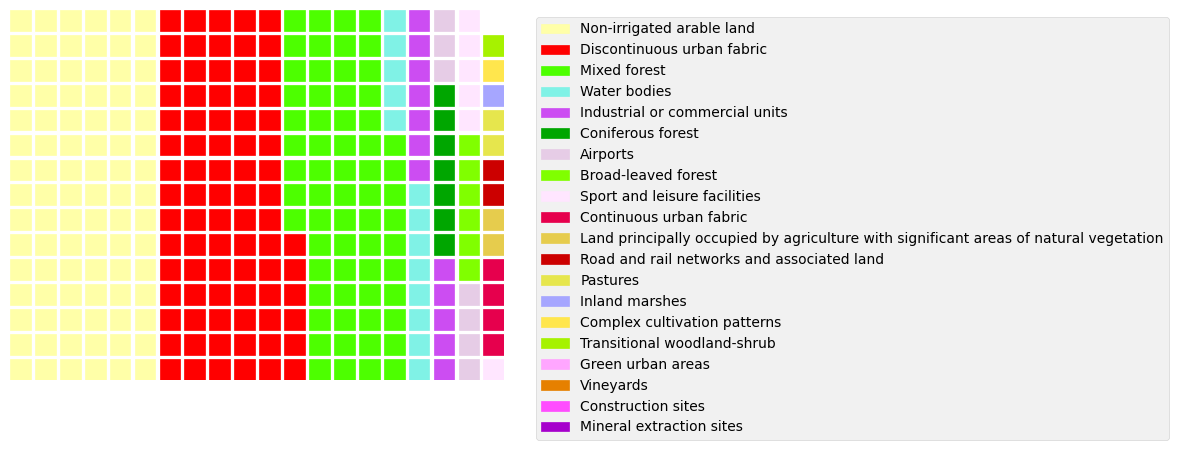

In [104]:
df_filtered = df[df['count'] != 0]
df_filtered
count = df_filtered['count'].tolist()
color_ramp = df_filtered['Color'].tolist()
labels = df_filtered['Classname'].tolist()

plt.figure(
    FigureClass=Waffle,
    rows=15,
    columns=20,
    values=count,
    labels=labels,
    colors=color_ramp,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
)
plt.show()

## 11. Creating Chloropeth maps based on your Statistical API inputs and outputs in Folium

### Creating an field of interest

In [108]:
nebraska_fields="""{
"type": "FeatureCollection",
"name": "nebraska_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965237618974555, 41.294115097043417 ], [ -93.96044820351797, 41.294062753705091 ], [ -93.960369688510482, 41.297674444049399 ], [ -93.95571113139971, 41.297700615718561 ], [ -93.95571113139971, 41.294272127058385 ], [ -93.957333774887729, 41.294167440381734 ], [ -93.957333774887729, 41.293172916953594 ], [ -93.955527929715572, 41.293329946968562 ], [ -93.955501758046424, 41.290424891691622 ], [ -93.965237618974555, 41.290555750037427 ], [ -93.965237618974555, 41.294115097043417 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.955318556362286, 41.301024417702095 ], [ -93.945949098802402, 41.301024417702095 ], [ -93.945844412125751, 41.297648272380236 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.936396439558393, 41.297648272380236 ], [ -93.936448782896719, 41.296182658907185 ], [ -93.937547993001502, 41.296156487238022 ], [ -93.937626508008989, 41.294115097043417 ], [ -93.955344728031449, 41.293984238697604 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.930062895621276, 41.300998246032933 ], [ -93.9302460973054, 41.294717045434133 ], [ -93.931737882447621, 41.294690873764971 ], [ -93.931764054116783, 41.294088925374254 ], [ -93.935663632821871, 41.294141268712579 ], [ -93.936187066205093, 41.294455328742515 ], [ -93.936082379528457, 41.301024417702095 ], [ -93.930062895621276, 41.300998246032933 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.96992234775449, 41.294062753705091 ], [ -93.970027034431141, 41.28694405969312 ], [ -93.974842621556888, 41.2870225747006 ], [ -93.974659419872751, 41.294141268712579 ], [ -93.96992234775449, 41.294062753705091 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.960552890194606, 41.294193612050897 ], [ -93.965159103967068, 41.294167440381734 ], [ -93.965159103967068, 41.30107676104042 ], [ -93.955737303068872, 41.301024417702095 ], [ -93.955789646407183, 41.297779130726049 ], [ -93.96044820351797, 41.297831474064367 ], [ -93.960552890194606, 41.294193612050897 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974894964895199, 41.283306197679643 ], [ -93.974973479902673, 41.279851537350304 ], [ -93.984133564109257, 41.279877709019466 ], [ -93.98415973577842, 41.283332369348805 ], [ -93.974894964895199, 41.283306197679643 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 8 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974711763211062, 41.286813201347307 ], [ -93.970027034431126, 41.286813201347307 ], [ -93.970079377769451, 41.279668335666173 ], [ -93.972225454640707, 41.279773022342816 ], [ -93.97225162630987, 41.28055817241767 ], [ -93.974790278218549, 41.280610515755995 ], [ -93.974711763211062, 41.286813201347307 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 9 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965342305651191, 41.294088925374254 ], [ -93.965394648989502, 41.289011621556888 ], [ -93.967802442552383, 41.289011621556888 ], [ -93.967907129229033, 41.287074918038925 ], [ -93.969974691092801, 41.2870225747006 ], [ -93.969870004416151, 41.294088925374254 ], [ -93.965342305651191, 41.294088925374254 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 10 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950790857597312, 41.290267861676654 ], [ -93.950869372604785, 41.286865544685639 ], [ -93.954324032934139, 41.286996403031445 ], [ -93.954297861264976, 41.288331158158691 ], [ -93.955344728031434, 41.288331158158691 ], [ -93.955318556362272, 41.290424891691622 ], [ -93.950790857597312, 41.290267861676654 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 11 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941146597511207, 41.304819309730554 ], [ -93.941225112518694, 41.301377735235796 ], [ -93.945752811283668, 41.301377735235796 ], [ -93.945726639614506, 41.304766966392229 ], [ -93.941146597511207, 41.304819309730554 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 12 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.94134288502994, 41.308378656736544 ], [ -93.941499915044915, 41.304950168076367 ], [ -93.945661210441614, 41.304897824738042 ], [ -93.945582695434126, 41.308378656736544 ], [ -93.94134288502994, 41.308378656736544 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 13 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941212026684127, 41.308247798390738 ], [ -93.939406181511984, 41.308326313398219 ], [ -93.939406181511984, 41.307488819985046 ], [ -93.938019083046413, 41.307514991654209 ], [ -93.938097598053901, 41.305002511414685 ], [ -93.941421400037427, 41.304897824738042 ], [ -93.941212026684127, 41.308247798390738 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 14 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.938385486414674, 41.300972074363791 ], [ -93.938411658083837, 41.300029894273969 ], [ -93.936317924550892, 41.300108409281457 ], [ -93.936422611227542, 41.297700615718583 ], [ -93.945765897118264, 41.297648272380258 ], [ -93.945949098802387, 41.300396297642237 ], [ -93.945085433720052, 41.301024417702116 ], [ -93.938385486414674, 41.300972074363791 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 15 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.984212079116745, 41.286917888023972 ], [ -93.980835933794893, 41.286878630520235 ], [ -93.980822847960312, 41.285713991242538 ], [ -93.979959182877977, 41.285635476235051 ], [ -93.979501178667647, 41.286028051272481 ], [ -93.978833801104017, 41.286852458851072 ], [ -93.974751020714805, 41.286878630520235 ], [ -93.974921136564348, 41.283371626852571 ], [ -93.984212079116745, 41.283384712687152 ], [ -93.984212079116745, 41.286917888023972 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 16 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.92668675029941, 41.308326313398226 ], [ -93.92668675029941, 41.301364649401215 ], [ -93.936082379528443, 41.30133847773206 ], [ -93.936056207859281, 41.308300141729063 ], [ -93.92668675029941, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 17 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.926529720284435, 41.308300141729063 ], [ -93.921818819835337, 41.308404828405706 ], [ -93.921897334842825, 41.30133847773206 ], [ -93.92658206362276, 41.301390821070378 ], [ -93.926529720284435, 41.308300141729063 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 19 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921687961489525, 41.308326313398226 ], [ -93.917291121070363, 41.308431000074869 ], [ -93.917317292739526, 41.301390821070378 ], [ -93.921792648166175, 41.30141699273954 ], [ -93.921687961489525, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 20 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921871163173662, 41.319239899438642 ], [ -93.917160262724565, 41.31921372776948 ], [ -93.917186434393727, 41.308588030089844 ], [ -93.9218449915045, 41.308640373428162 ], [ -93.921871163173662, 41.319239899438642 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 21 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.914595439146723, 41.308352485067388 ], [ -93.914490752470073, 41.301443164408703 ], [ -93.917134091055402, 41.301364649401222 ], [ -93.917081747717077, 41.308457171744031 ], [ -93.914595439146723, 41.308352485067388 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 22 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950659999251513, 41.292191479360064 ], [ -93.950699256755243, 41.290725865887005 ], [ -93.95225647107037, 41.290660436714106 ], [ -93.952361157747021, 41.290398720022488 ], [ -93.9546904363024, 41.290464149195394 ], [ -93.954716607971562, 41.291249299270241 ], [ -93.954363290437882, 41.291733475149734 ], [ -93.954245517926651, 41.292230736863807 ], [ -93.950659999251513, 41.292191479360064 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 23 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955331642196867, 41.293971152863058 ], [ -93.945949098802402, 41.293984238697639 ], [ -93.945975270471564, 41.290464149195394 ], [ -93.95051605507112, 41.290503406699138 ], [ -93.950489883401957, 41.292243822698389 ], [ -93.955423243038936, 41.29233542354045 ], [ -93.955331642196867, 41.293971152863058 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 24 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.943763764427416, 41.292688741074137 ], [ -93.943763764427416, 41.290385634187913 ], [ -93.945962184636997, 41.290464149195401 ], [ -93.945857497960347, 41.294023496201383 ], [ -93.939864185722328, 41.293971152863065 ], [ -93.939942700729816, 41.291589530969354 ], [ -93.942167292608545, 41.291694217645997 ], [ -93.94313564436753, 41.292741084412462 ], [ -93.943763764427416, 41.292688741074137 ] ] ] ] } }
]
}

"""

In [109]:
fields_gdf = geopandas.read_file(nebraska_fields)

#fields_gdf
fields_gdf["area"] = fields_gdf.area
fields_gdf.explore("area", cmap="tab10", legend=False)

### The Evalscript

In [110]:
evalscript = """
//VERSION=3
//NDVI

function setup() {
  return {
    input: [{
      bands: [
        "red",
        "nir",
        "dataMask",
        "cloud_mask"
      ]
    }],
    output: [
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(samples) {
  let ndvi = (samples.nir - samples.red) / (samples.nir + samples.red);
  const indexVal = samples.dataMask === 1 ? ndvi : NaN;
  const clear = samples.dataMask * samples.cloud_mask;
  

  return {
    index: [indexVal],
    dataMask: [clear], // change 'samples.dataMask' to 'clear' to mask out cloudy pixels using the 'clear' band
  };
}
"""

### The Request Body

In [111]:
config = SHConfig("SH_creds")

fields_gdf = geopandas.read_file(nebraska_fields)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-07-15T00:00:00Z', '2022-07-16T23:59:59Z'),
        aggregation_interval='P1D',
        size=[2500,1751],        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc('3f605f75-86c4-411a-b4ae-01c896f0e54e'))

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [112]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 217 ms, sys: 70.5 ms, total: 288 ms
Wall time: 40.4 s


23

### The Request Body

### Manipulation and Visualisation of our Output

In [113]:
ndvi_dfs = [stats_to_df(polygon_stats) for polygon_stats in ndvi_stats]

for df, id in zip(ndvi_dfs, fields_gdf["id"].values):
    df["id"] = id

ndvi_df = pd.concat(ndvi_dfs)

ndvi_df

interval_from interval_to  index_B0_min  index_B0_max  index_B0_mean  \
0    2022-07-15  2022-07-16      0.236313      0.921176       0.873099   
0    2022-07-15  2022-07-16      0.354721      0.864069       0.743077   
0    2022-07-15  2022-07-16      0.480832      0.923797       0.877969   
0    2022-07-15  2022-07-16      0.290623      0.817068       0.708995   
0    2022-07-15  2022-07-16      0.249090      0.931954       0.889785   
0    2022-07-15  2022-07-16      0.606278      0.912379       0.797515   
0    2022-07-15  2022-07-16      0.569164      0.863495       0.757278   
0    2022-07-15  2022-07-16      0.411697      0.866719       0.756490   
0    2022-07-15  2022-07-16      0.507060      0.790162       0.672533   
0    2022-07-15  2022-07-16      0.507034      0.770369       0.649060   
0    2022-07-15  2022-07-16      0.528239      0.840999       0.738359   
0    2022-07-15  2022-07-16      0.618644      0.846289       0.727440   
0    2022-07-15  2022-07-16      0.717322      0.920368       0.888860   
0    2022-07-15  2022-07-16      0.384229      0.829468       0.736429   
0    2022-07-15  2022-07-16      0.248873      0.921577       0.818900   
0    2022-07-15  2022-07-16      0.512844      0.916376       0.827727   
0    2022-07-15  2022-07-16      0.579378      0.937584       0.907777   
0    2022-07-15  2022-07-16      0.239720      0.926927       0.888156   
0    2022-07-15  2022-07-16      0.306842      0.847591       0.651938   
0    2022-07-15  2022-07-16      0.251813      0.891822       0.763067   
0    2022-07-15  2022-07-16      0.663989      0.915573       0.865627   
0    2022-07-15  2022-07-16      0.415969      0.816243       0.640311   
0    2022-07-15  2022-07-16      0.386160      0.922968       0.736194   

   index_B0_stDev  index_B0_sampleCount  index_B0_noDataCount  id  
0        0.055348               4377500               1273825   1  
0        0.030681               4377500                 71427   2  
0        0.030122               4377500                286018   3  
0        0.055977               4377500                228060   4  
0        0.055781               4377500                169147   5  
0        0.040797               4377500               1188633   6  
0        0.043746               4377500                 53492   7  
0        0.033786               4377500                367796   8  
0        0.043550               4377500                739752   9  
0        0.028221               4377500                605607  10  
0        0.036354               4377500                 80224  11  
0        0.027012               4377500                149491  12  
0        0.016590               4377500                695129  13  
0        0.054122               4377500                408128  14  
0        0.081391               4377500                327398  15  
0        0.045607               4377500                 19506  16  
0        0.023120               4377500                104431  17  
0        0.036877               4377500                100226  19  
0        0.087525               4377500                 36536  20  
0        0.069248               4377500                181098  21  
0        0.029188               4377500                563289  22  
0        0.057316               4377500               1210906  23  
0        0.131962               4377500               1307420  24

In [114]:
mean_ndvi = ndvi_df['index_B0_mean'].tolist()
fields_gdf.insert(1, "mean_ndvi", mean_ndvi)

In [119]:
fields_gdf.explore(column='mean_ndvi', cmap='OrRd', legend=True)